In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)


In [21]:
df = pd.read_csv('Loan_Default.csv')

In [22]:
df.drop(columns=['age','ID', 'loan_type', 'Credit_Worthiness', 'lump_sum_payment', 'Gender', 'construction_type', 'Secured_by', 'total_units', 
                 'credit_type', 'co-applicant_credit_type', 'Region', 'year', 
                 'submission_of_application', 'loan_purpose','open_credit', 'Security_Type'], 
        inplace=True)


In [23]:
df.describe()


,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000


**Duplicate Records**

In [24]:
print(len(df[df.duplicated() == True]))

15


In [25]:
df = df.drop_duplicates()
print('No of dup. records: ', len(df[df.duplicated() == True]))

No of dup. records:  0


**Missing Records Analysis**

Percentage of missing data in each column

In [26]:

round(df.isna().sum()/df.count() * 100,2).sort_values()

business_or_commercial     0.00
loan_amount                0.00
Credit_Score               0.00
occupancy_type             0.00
interest_only              0.00
Status                     0.00
term                       0.03
Neg_ammortization          0.08
approv_in_adv              0.61
loan_limit                 2.30
income                     6.56
property_value            11.29
LTV                       11.29
dtir1                     19.35
rate_of_interest          32.45
Interest_rate_spread      32.69
Upfront_charges           36.35
dtype: float64

Fill missing values with median

In [27]:
columns_to_fill = ['income', 'property_value', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges','term']
for column in columns_to_fill:
    df[column].fillna(df[column].median(), inplace=True)

Verify - exclude status

In [28]:
columns_to_check = df.columns.difference(['Status'])
for column in columns_to_check:
    zero_count = (df[column] == 0).sum()  
    print(f"Column '{column}' contains {zero_count} zeros.")

Column 'Credit_Score' contains 0 zeros.
Column 'Interest_rate_spread' contains 9 zeros.
Column 'LTV' contains 0 zeros.
Column 'Neg_ammortization' contains 0 zeros.
Column 'Upfront_charges' contains 20770 zeros.
Column 'approv_in_adv' contains 0 zeros.
Column 'business_or_commercial' contains 0 zeros.
Column 'dtir1' contains 0 zeros.
Column 'income' contains 1255 zeros.
Column 'interest_only' contains 0 zeros.
Column 'loan_amount' contains 0 zeros.
Column 'loan_limit' contains 0 zeros.
Column 'occupancy_type' contains 0 zeros.
Column 'property_value' contains 0 zeros.
Column 'rate_of_interest' contains 1 zeros.
Column 'term' contains 0 zeros.


In [29]:
missing_income_per_class = df[df['income'].isna()].groupby('Status')['income'].count()

print(missing_income_per_class)


Series([], Name: income, dtype: int64)


In [30]:
income_median = df['income'].median()
df['income'] = df['income'].replace(0, income_median)

LTV and DTIR for new values

In [31]:
df['LTV'] = df['LTV'].fillna(df['loan_amount'] / df['property_value'])
df['dtir1'] = df['dtir1'].fillna(df['loan_amount'] / df['income'])

In [32]:
df.describe()

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,1.486550e+05,148655.000000,148655.000000,148655.000000,148655.000000,1.486550e+05,148655.000000,148655.000000,148655.000000,148655.000000,148655.000000
mean,3.311259e+05,4.031883,0.429028,3057.444431,335.140930,4.897901e+05,6932.672160,699.790495,65.444246,0.246369,41.226982
std,1.839140e+05,0.488372,0.445929,2798.110295,58.404901,3.420370e+05,6269.043134,115.875534,43.674443,0.430897,19.380752
min,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,60.000000,500.000000,0.039474,0.000000,1.961806
25%,1.965000e+05,3.750000,0.181500,1250.000000,360.000000,2.880000e+05,3900.000000,599.000000,54.590395,0.000000,32.000000
50%,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,73.026316,0.000000,40.000000
75%,4.365000e+05,4.250000,0.620050,3890.000000,360.000000,5.980000e+05,8280.000000,800.000000,84.722222,0.000000,47.000000
max,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,2455.000000


**Mapping values**

In [33]:
df['loan_limit'] = df['loan_limit'].map({'cf': 1, 'ncf': 0})

df['approv_in_adv'] = df['approv_in_adv'].map({'nopre': 0, 'pre': 1})


df['business_or_commercial'] = df['business_or_commercial'].map({'nob/c': 0, 'b/c': 1})

df['Neg_ammortization'] = df['Neg_ammortization'].map({'not_neg':0, 'neg_amm':1})

df['interest_only'] = df['interest_only'].map({'not_int':0, 'int_only':1})

df['occupancy_type'] = df['occupancy_type'].map({'pr': 0, 'sr': 0, 'ir': 1})

**Feature Correlation**

                        loan_limit  approv_in_adv  business_or_commercial  \
loan_limit                1.000000      -0.096434                0.022561   
approv_in_adv            -0.096434       1.000000                0.010138   
business_or_commercial    0.022561       0.010138                1.000000   
loan_amount              -0.281012      -0.030102               -0.162476   
rate_of_interest         -0.024012       0.053385               -0.046495   
Interest_rate_spread      0.031190       0.058256                0.317786   
Upfront_charges          -0.030503       0.020003               -0.130440   
term                     -0.019397       0.024201                0.093308   
Neg_ammortization        -0.008058      -0.078270                0.014391   
interest_only             0.031094      -0.074572               -0.007074   
property_value           -0.189347      -0.049311               -0.204149   
occupancy_type            0.015322      -0.002025               -0.091634   

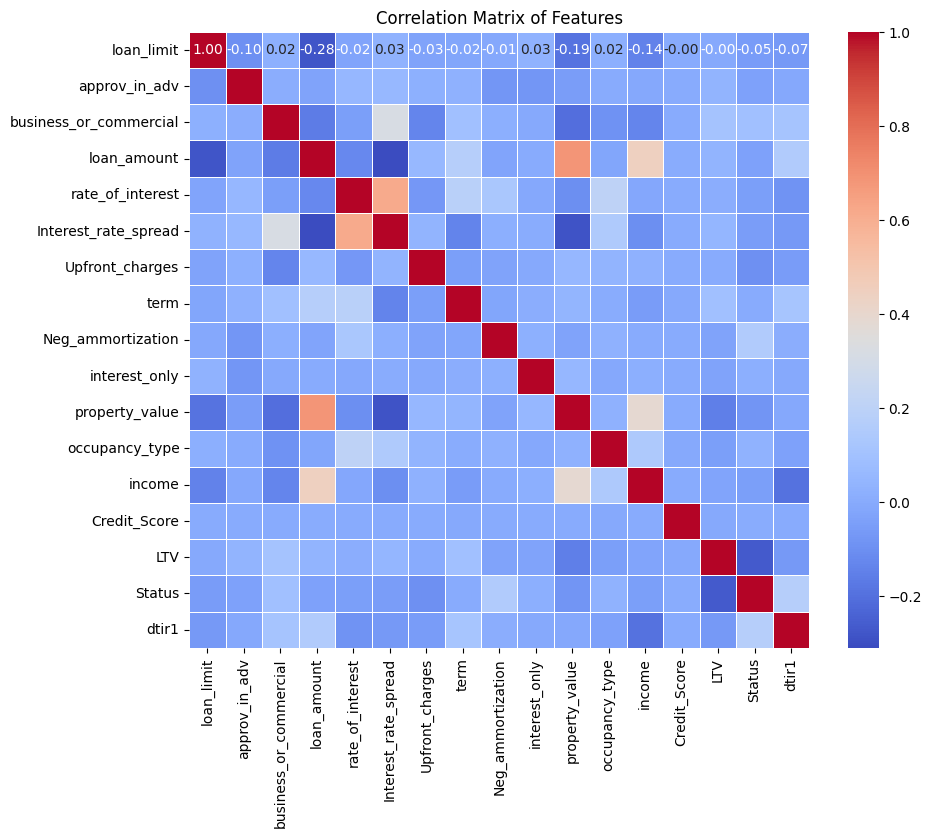

Status                    1.000000
dtir1                     0.176509
Neg_ammortization         0.156005
business_or_commercial    0.092476
occupancy_type            0.028294
interest_only             0.013923
Credit_Score              0.004026
term                     -0.000282
loan_amount              -0.036755
approv_in_adv            -0.037326
rate_of_interest         -0.046730
income                   -0.047368
Interest_rate_spread     -0.049528
loan_limit               -0.054320
property_value           -0.080867
Upfront_charges          -0.095079
LTV                      -0.265075
Name: Status, dtype: float64


In [34]:
correlation_matrix = df.corr()
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()
target_corr = df.corr()['Status'].sort_values(ascending=False)
print(target_corr)

In [35]:
df.drop(columns=['Upfront_charges', 'Interest_rate_spread', 'Neg_ammortization', 'business_or_commercial', 'approv_in_adv', 'loan_limit', 'interest_only', 'occupancy_type'], inplace=True)


In [36]:
print(df['Status'].value_counts())

0    112031
1     36624
Name: Status, dtype: int64


In [37]:
X = df.drop(columns=['Status'])
y = df['Status']

In [38]:
print(X.dtypes)

loan_amount           int64
rate_of_interest    float64
term                float64
property_value      float64
income              float64
Credit_Score          int64
LTV                 float64
dtir1               float64
dtype: object


array([[<Axes: title={'center': 'loan_amount'}>,
        <Axes: title={'center': 'rate_of_interest'}>,
        <Axes: title={'center': 'term'}>],
       [<Axes: title={'center': 'property_value'}>,
        <Axes: title={'center': 'income'}>,
        <Axes: title={'center': 'Credit_Score'}>],
       [<Axes: title={'center': 'LTV'}>,
        <Axes: title={'center': 'Status'}>,
        <Axes: title={'center': 'dtir1'}>]], dtype=object)

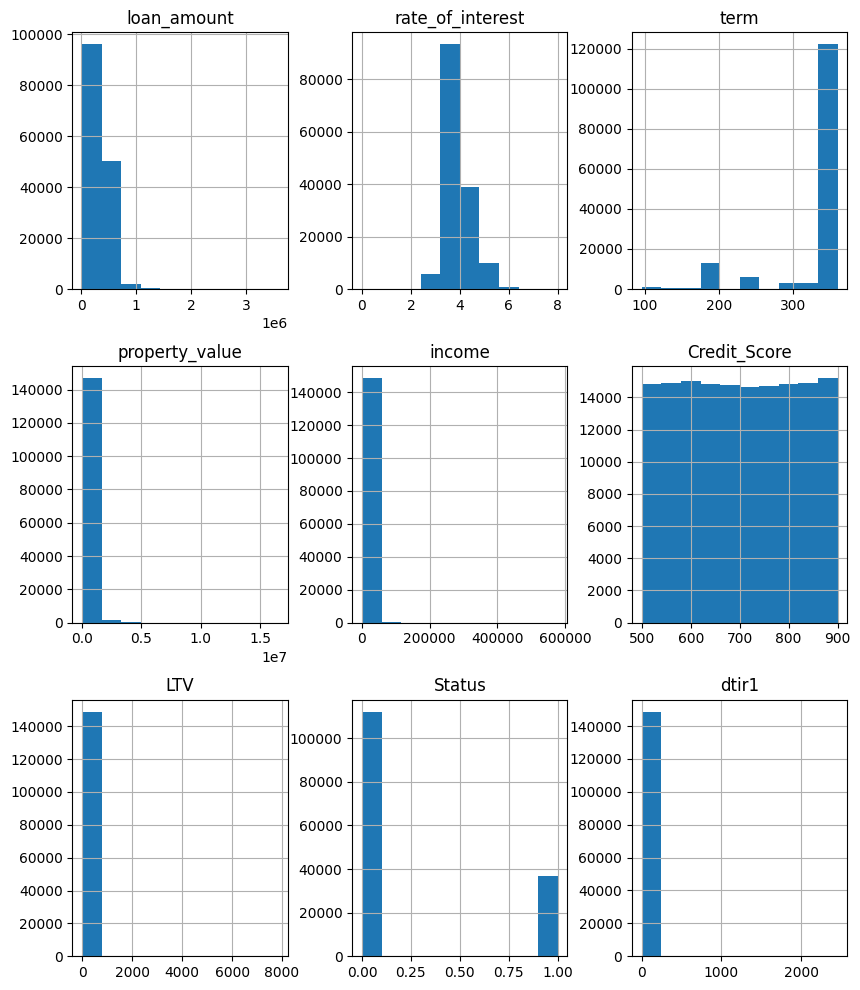

In [39]:
df.hist(figsize=(10, 12))

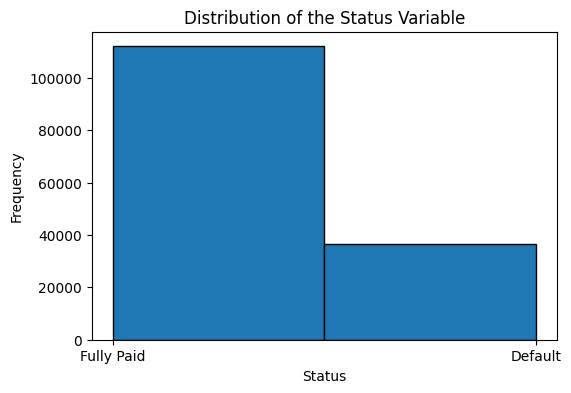

In [40]:
plt.figure(figsize=(6, 4))
plt.hist(df['Status'], bins=2, edgecolor='black')
plt.title('Distribution of the Status Variable')
plt.xlabel('Status')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Fully Paid', 'Default'])
plt.show()


In [41]:
# df.to_csv("Loan_Default_Cleaned.csv", index=False)